In [12]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in combined sample S2/S3

In [13]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [14]:
import importlib

## Preprocessing
### Read data

In [36]:
data_path = "../../data/MOBA_scRNAseq"
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")


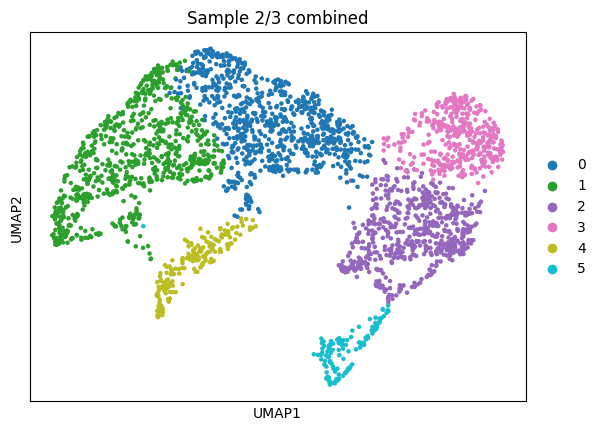

In [37]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2/3 combined")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [35]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params


KeyboardInterrupt: 

## Find optimal correlation matrix scaling and generate synthetic null data

In [ ]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

In [ ]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [ ]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [ ]:
data_null_gen.var_names

In [ ]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [ ]:
data_null_gen.var

In [ ]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

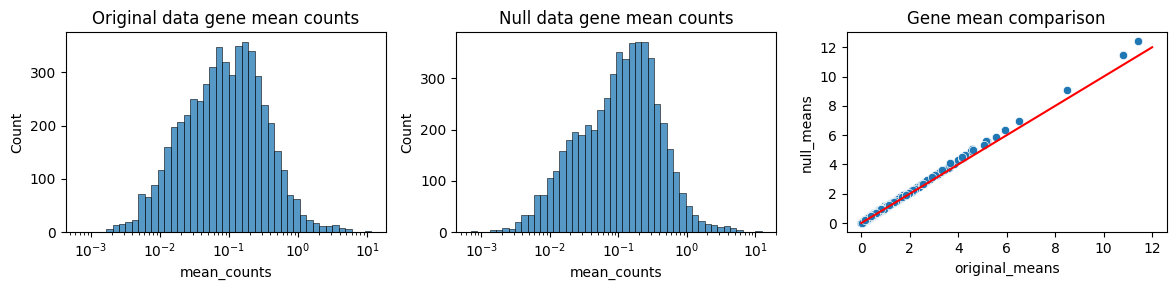

SignificanceResult(statistic=0.9982847346133448, pvalue=0.0)


In [39]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

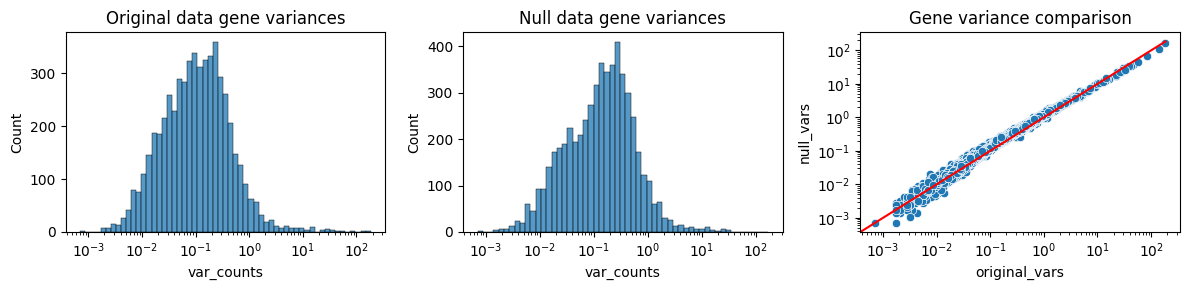

SignificanceResult(statistic=0.9968518759773922, pvalue=0.0)
[[1.         0.99703966]
 [0.99703966 1.        ]]


In [40]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

In [42]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

KeyboardInterrupt: 

### Process null data

In [22]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [23]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


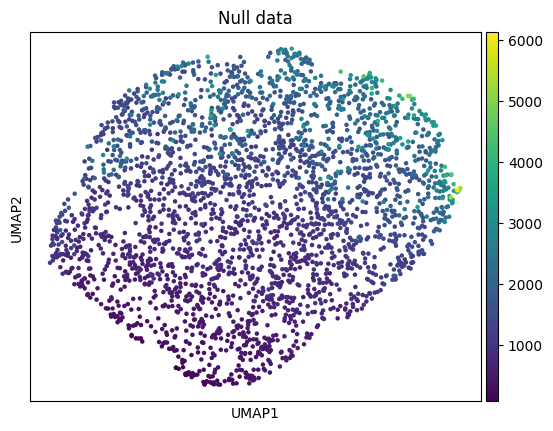

In [24]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [25]:
data_path = "../../data/MOBA_scRNAseq"
data_null_gen.write(data_path + "/null_data_S2S3_combined.h5ad")

In [38]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_S2S3_combined.h5ad")
data_null_gen

AnnData object with n_obs × n_vars = 2840 × 5556
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'var_counts', 'mean_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [43]:
n_splits = 20
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = 0
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            elif max_res_1_cluster > 0: 
                res_step = res_step / 2
            if was_greater:
                res2 += res_step
            else:
                res2 += res_step * 5
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}, step: {res_step}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

resolution: 0.06, clusters: 1, step: 0.01
resolution: 0.11, clusters: 2, step: 0.01
split 1/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 2/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 3/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 4/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 5/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 6/20 - Resolution 0.11
resolution: 0.11, clusters: 2, step: 0.01
split 7/20 - Resolution 0.11
resolution: 0.11, clusters: 1, step: 0.01
resolution: 0.16, clusters: 3, step: 0.01
resolution: 0.15, clusters: 3, step: 0.01
resolution: 0.14, clusters: 3, step: 0.01
resolution: 0.13, clusters: 3, step: 0.01
resolution: 0.12, clusters: 2, step: 0.01
split 8/20 - Resolution 0.12
resolution: 0.12, clusters: 2, step: 0.01
split 9/20 - Resolution 0.12
resolution: 0.12, clusters: 2, step: 0.01
split 10/20 - Resolution 0.12
resolution: 0.12, clusters: 2, step: 

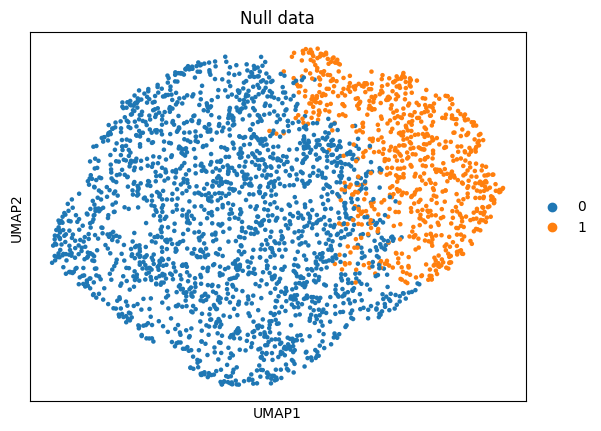

In [44]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [45]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals_dict[best_split]}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 3 - DE genes: 0; Minimum q value: 0.42857142857142855
Cluster 1 - DE genes: 26; Minimum q value: 0.038461538461538464
Cluster 2 - DE genes: 53; Minimum q value: 0.023809523809523808
Cluster 0 - DE genes: 0; Minimum q value: 1.0
Cluster 4 - DE genes: 0; Minimum q value: 1.0
Cluster 5 - DE genes: 0; Minimum q value: 0.08333333333333333


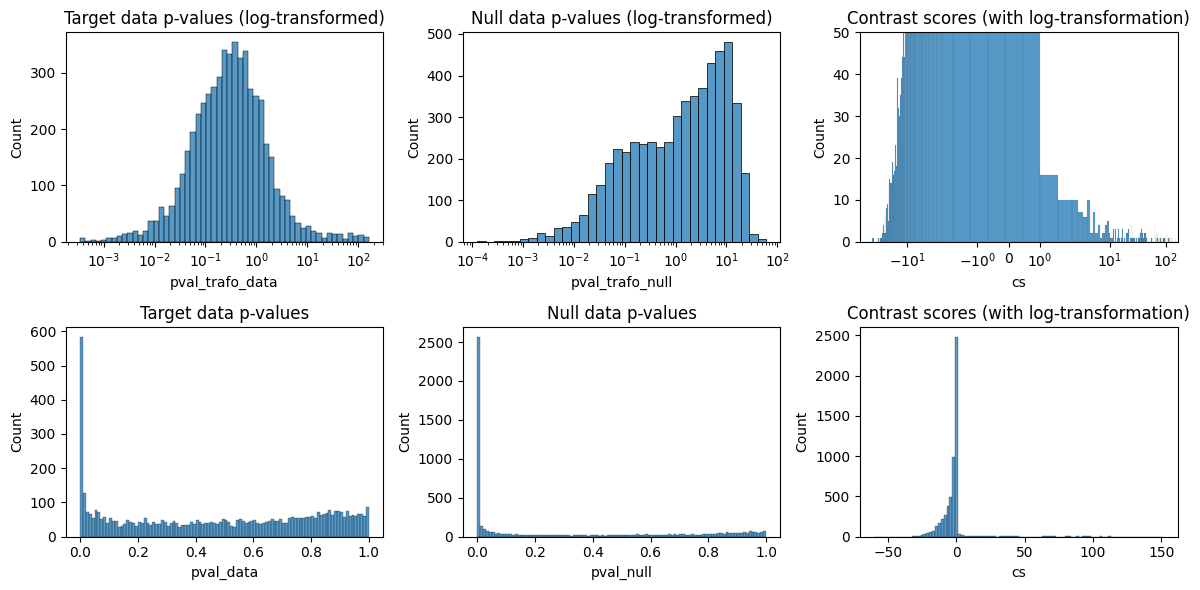

In [46]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [47]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 3
0.428571      14
0.625000       2
0.705882       1
0.722222       1
0.750000       2
0.760000       5
1.000000    5531
Name: q, dtype: int64

cluster 1
0.038462      26
0.057692      26
0.074074       2
0.089286       2
0.105263       1
0.150000       3
0.196721       1
0.222222       2
0.261538       2
0.285198    4083
0.285234      17
0.285646       1
0.285885      28
0.286089       4
0.286497       1
0.286564       6
0.286732       8
0.286833       2
0.286864      10
0.286897       3
0.287066       1
0.287403       2
0.287571       1
0.287671       2
0.287904       7
0.287936       3
0.288104       1
0.288507       1
0.288972       7
0.289307       2
0.289474       1
0.290406       7
0.291041       1
0.291911       1
0.292243       2
0.292409       1
0.292574       1
0.293071       3
0.293237       1
0.293333       2
0.293430       2
0.293760       2
0.294214       7
0.294845       1
1.000000    1269
Name: q, dtype: int64

cluster 2
0.023810      42
0.037736      11
0.0535

In [48]:
pvals_log_gen["0"]

pval_data     pval_null  pval_trafo_data  pval_trafo_null  \
PA4244  6.982421e-25  1.028486e-02        24.155994         1.987801   
PA1800  5.078155e-11  2.209654e-01        10.294294         0.655676   
PA4245  5.870950e-12  2.050812e-02        11.231292         1.688074   
PA3701  1.289187e-14  9.146614e-06        13.889684         5.038740   
PA4514  3.242633e-09  9.205836e-01         8.489102         0.035937   
...              ...           ...              ...              ...   
PA4260  7.146831e-09  1.889446e-45         8.145887        44.723665   
PA0550  1.157110e-01  1.144220e-42         0.936625        41.941490   
PA3984  6.320448e-05  8.202935e-49         4.199252        48.086031   
PA1838  1.544402e-07  6.538540e-61         6.811240        60.184519   
PA2201  9.913753e-01  2.882857e-60         0.003762        59.540177   

               cs    q  
PA4244  22.168193  1.0  
PA1800   9.638618  1.0  
PA4245   9.543217  1.0  
PA3701   8.850944  1.0  
PA4514   8.453165  1.0  
...           ...  ...  
PA4260 -36.577779  1.0  
PA0550 -41.004865  1.0  
PA3984 -43.886779  1.0  
PA1838 -53.373280  1.0  
PA2201 -59.536415  1.0  

[5556 rows x 6 columns]

In [49]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [50]:
data_gene_nonzero.write(data_path + "/S2S3_combined_data_maxpool_processed_cluster.h5ad")

In [51]:
data_gene_nonzero = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed_cluster.h5ad")

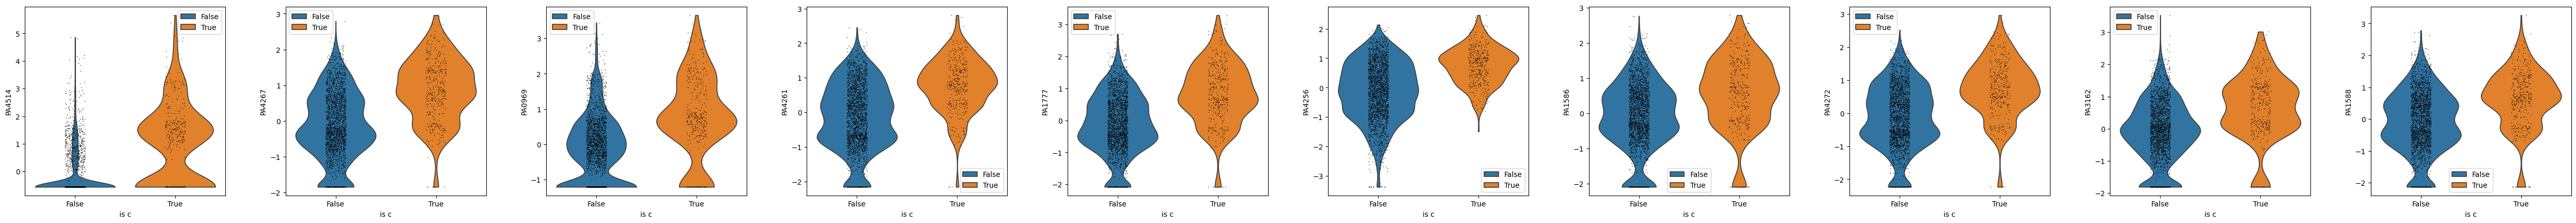

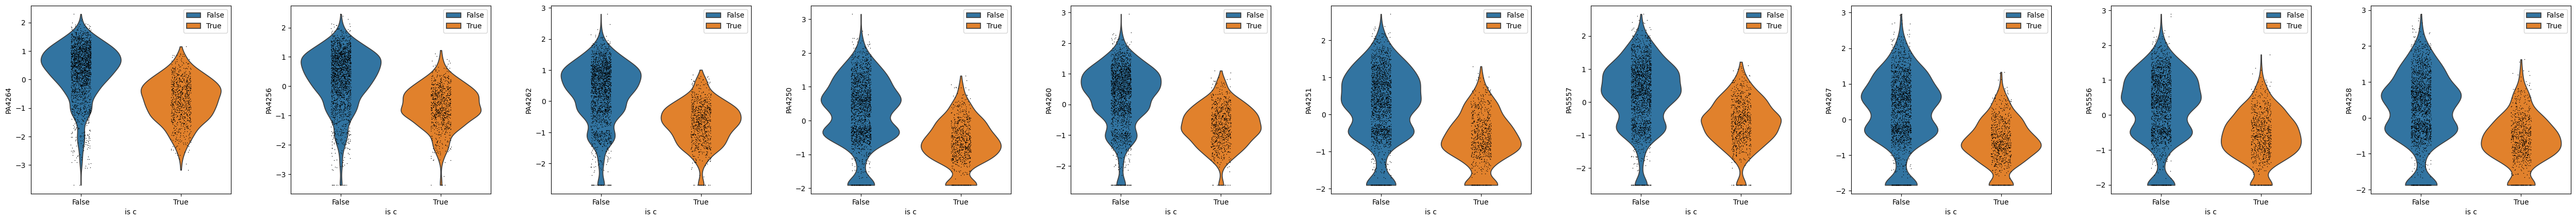

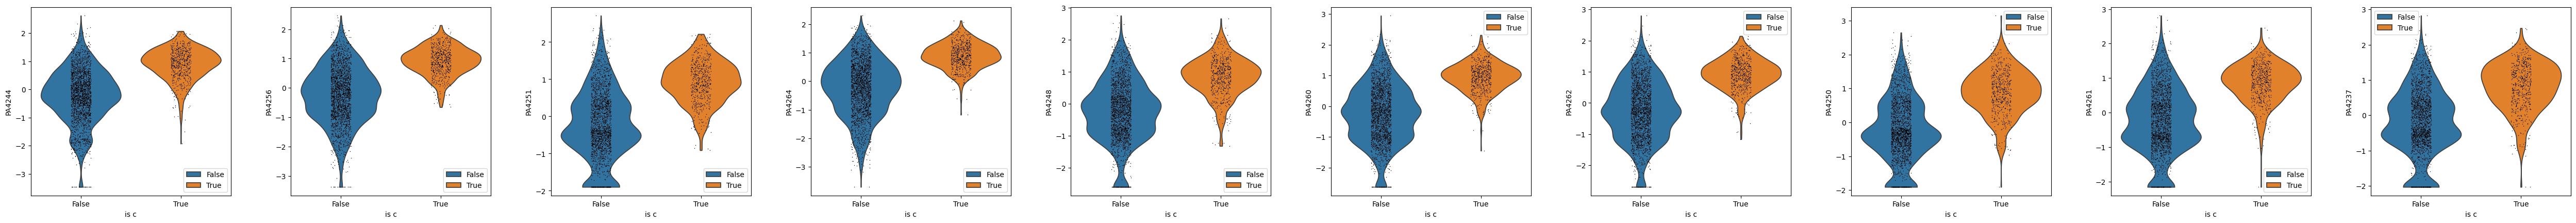

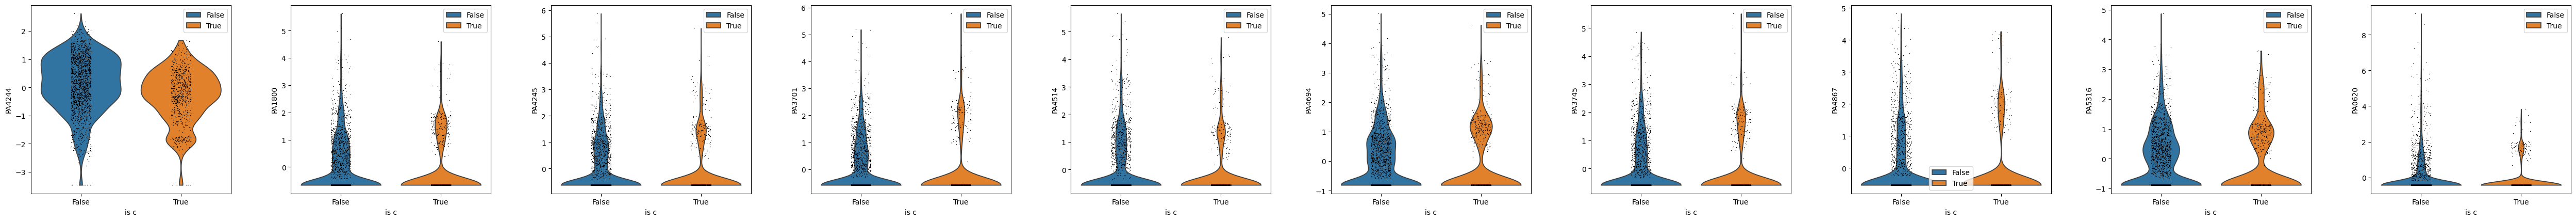

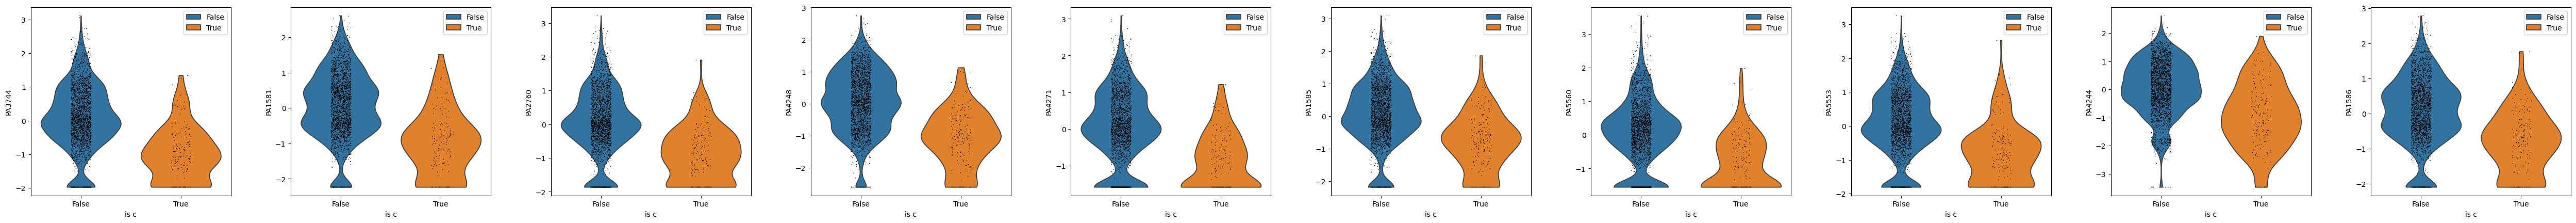

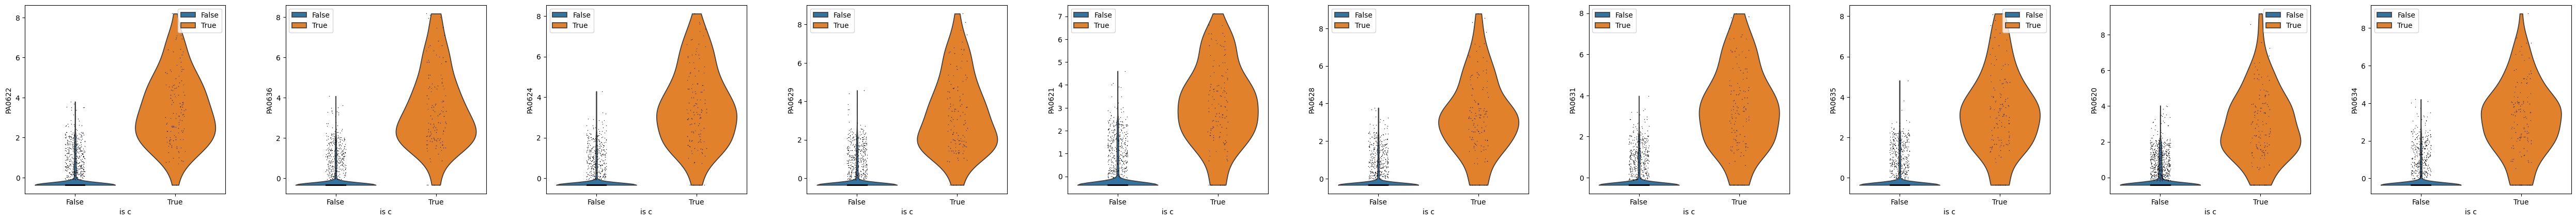

In [52]:
clusters = data_gene.obs["leiden_opt"].unique()
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [53]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                       
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
index                                                                      
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  ...    nb_umi  \
index                                            ...             
PA0001    0.740404           False    14.352036  ...  2.172720   
PA0002    0.605374           False    10.736381  ...  2.265225   
PA0003    1.239585           False    14.461098  ...  2.114107   
PA0004    0.415473           False     8.356774  ...  2.332144   
PA0005    0.143436           False     2.177469  ...  2.596174   
...            ...             ...          ...  ...       ...   
PA5566    0.008391           False     0.098094  ...  2.710316   
PA5567    0.161604           False     2.375922  ...  2.583191   
PA5568    0.748470           False    14.096996  ...  2.180212   
PA5569   14.483975           False     5.250319  ...  2.050410   
PA5570    0.667387           False     9.090777  ...  2.310420   

        Intercept_step1_sct  log_umi_step1_sct  dispersion_step1_sct  \
index                                                                  
PA0001            -6.763745           2.070944              0.009562   
PA0002                  NaN                NaN                   NaN   
PA0003                  NaN                NaN                   NaN   
PA0004                  NaN                NaN                   NaN   
PA0005                  NaN                NaN                   NaN   
...                     ...                ...                   ...   
PA5566                  NaN                NaN                   NaN   
PA5567                  NaN                NaN                   NaN   
PA5568            -6.983166           2.132635              0.010138   
PA5569            -5.772378           2.282947              0.085403   
PA5570                  NaN                NaN                   NaN   

            mean       std  Locus tag  Protein accession  \
index                                                      
PA0001  1.380827  0.140674     PA0001        NP_064721.1   
PA0002  1.079745  0.157803     PA0002        NP_064722.1   
PA0003  1.422187  0.159145     PA0003        NP_064723.1   
PA0004  0.825503  0.170925     PA0004        NP_064724.1   
PA0005 -0.531116  0.254086     PA0005        NP_064725.1   
...      

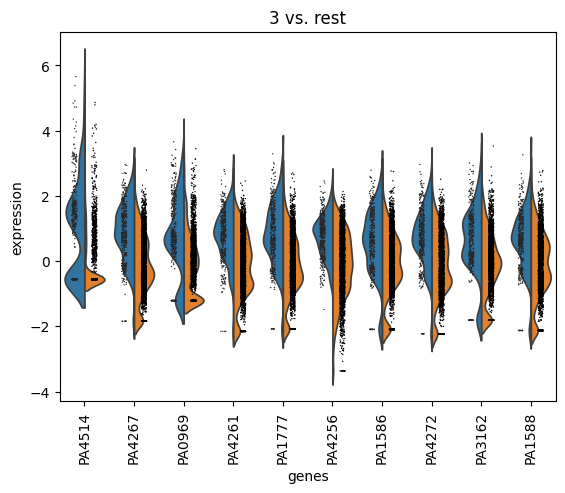

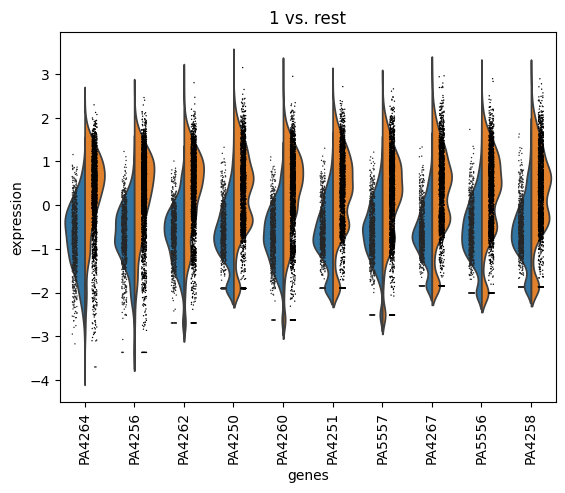

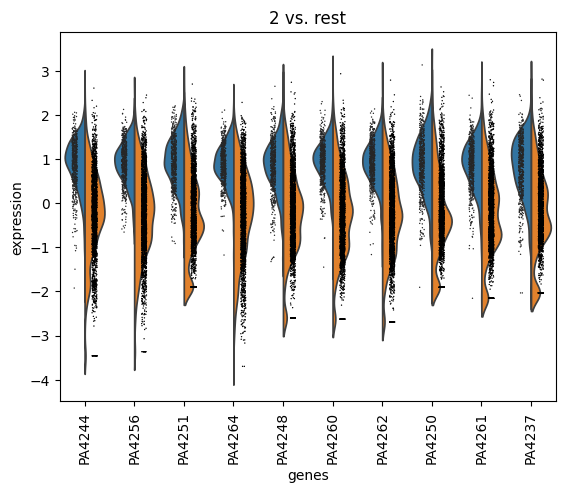

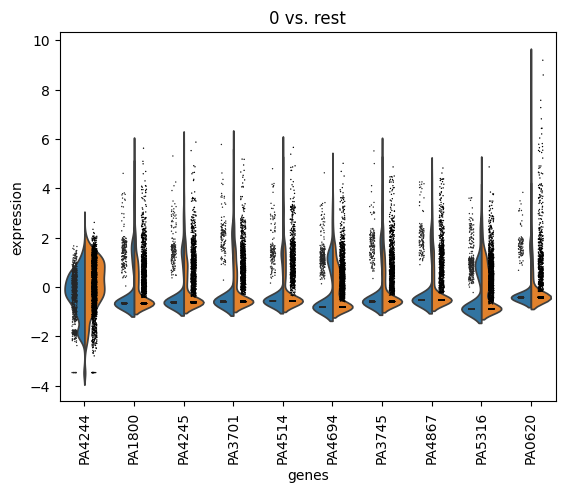

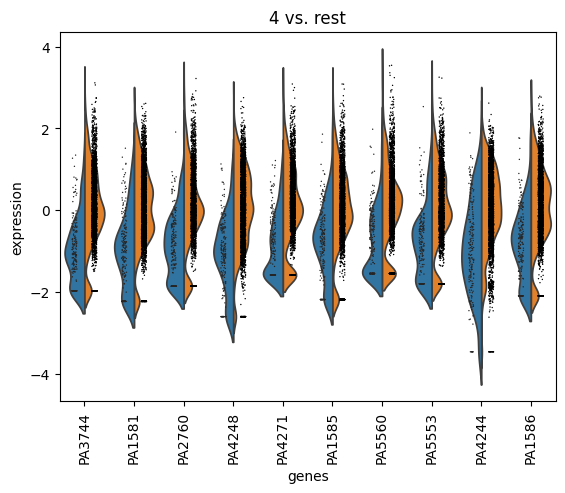

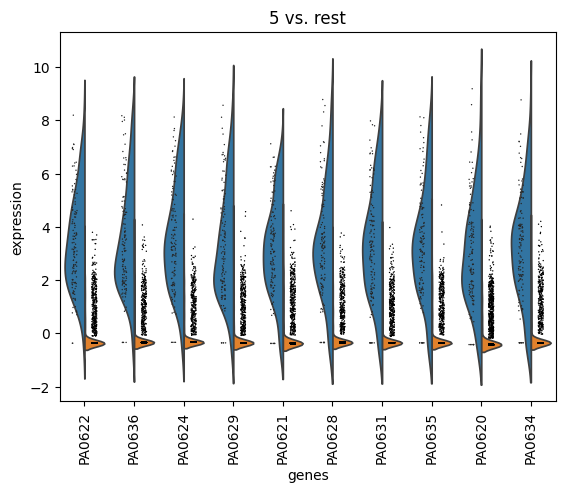

In [54]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [55]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                       
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
index                                                                      
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  ...    nb_umi  \
index                                            ...             
PA0001    0.740404           False    14.352036  ...  2.172720   
PA0002    0.605374           False    10.736381  ...  2.265225   
PA0003    1.239585           False    14.461098  ...  2.114107   
PA0004    0.415473           False     8.356774  ...  2.332144   
PA0005    0.143436           False     2.177469  ...  2.596174   
...            ...             ...          ...  ...       ...   
PA5566    0.008391           False     0.098094  ...  2.710316   
PA5567    0.161604           False     2.375922  ...  2.583191   
PA5568    0.748470           False    14.096996  ...  2.180212   
PA5569   14.483975           False     5.250319  ...  2.050410   
PA5570    0.667387           False     9.090777  ...  2.310420   

        Intercept_step1_sct  log_umi_step1_sct  dispersion_step1_sct  \
index                                                                  
PA0001            -6.763745           2.070944              0.009562   
PA0002                  NaN                NaN                   NaN   
PA0003                  NaN                NaN                   NaN   
PA0004                  NaN                NaN                   NaN   
PA0005                  NaN                NaN                   NaN   
...                     ...                ...                   ...   
PA5566                  NaN                NaN                   NaN   
PA5567                  NaN                NaN                   NaN   
PA5568            -6.983166           2.132635              0.010138   
PA5569            -5.772378           2.282947              0.085403   
PA5570                  NaN                NaN                   NaN   

            mean       std  Locus tag  Protein accession  \
index                                                      
PA0001  1.380827  0.140674     PA0001        NP_064721.1   
PA0002  1.079745  0.157803     PA0002        NP_064722.1   
PA0003  1.422187  0.159145     PA0003        NP_064723.1   
PA0004  0.825503  0.170925     PA0004        NP_064724.1   
PA0005 -0.531116  0.254086     PA0005        NP_064725.1   
...      

In [56]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

Cluster 3
       Locus tag                                               Name Symbol
index                                                                     
PA4514    PA4514             iron transport outer membrane receptor    NaN
PA4267    PA4267                           30S ribosomal protein S7   rpsG
PA0969    PA0969                         translocation protein TolQ   tolQ
PA4261    PA4261                          50S ribosomal protein L23   rplW
PA1777    PA1777                             outer membrane porin F   oprF
PA4256    PA4256                          50S ribosomal protein L16   rplP
PA1586    PA1586  2-oxoglutarate dehydrogenase complex dihydroli...   sucB
PA4272    PA4272                          50S ribosomal protein L10   rplJ
PA3162    PA3162                           30S ribosomal protein S1   rpsA
PA1588    PA1588                   succinyl-CoA ligase subunit beta   sucC
Cluster 1
       Locus tag                        Name Symbol
index                       

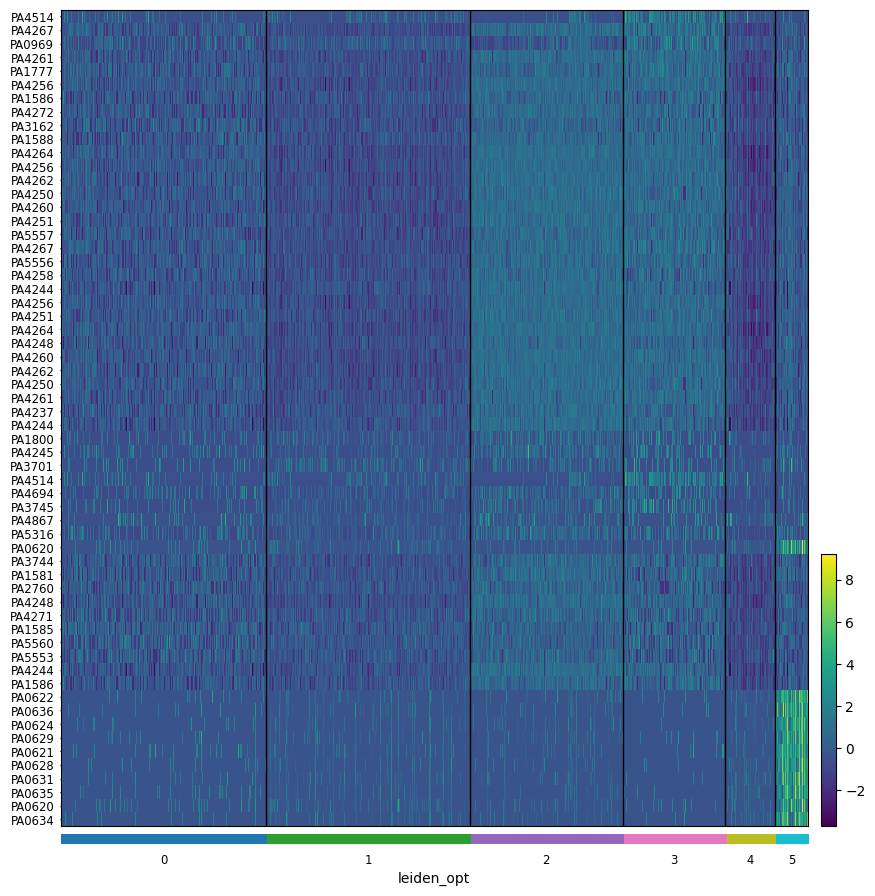

In [57]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes

sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)

In [58]:
!pip install pertpy[coda]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 184.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 156.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 150.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 kB 134.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 140.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 79.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 132.6 MB/s eta 0:00:00
  Created wheel for blitzgsea: filename=blitzgsea-1.3.40-py3-none-any.whl size=97418 sha256=0977c6d1d810e554909a18a793be9de3719098f1c3f04ccf7ff3cd2e819545cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-fay424yy/wheels/b2/2b/df/7598cb2e21c3c71256069a9c1b6f08143120a62de9

In [59]:
import pertpy as pt


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

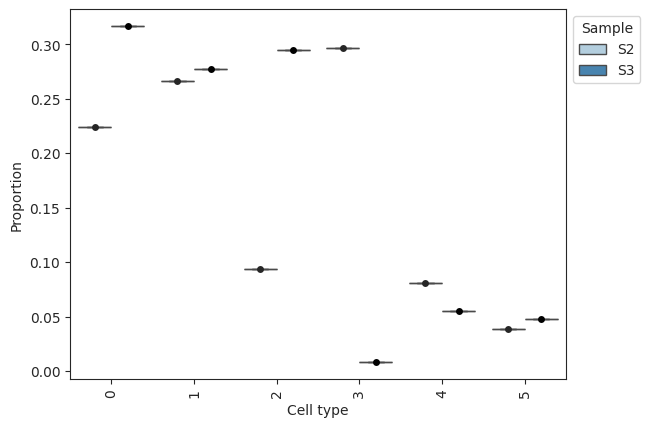

In [60]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    data_gene_nonzero,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden_opt",
    sample_identifier=["Sample"],
)
sccoda_data["coda"].obs["Sample"] = sccoda_data["coda"].obs.index
# plot boxplots
pt.pl.coda.boxplots(sccoda_data, modality_key="coda", feature_name="Sample", add_dots=True)
plt.show()

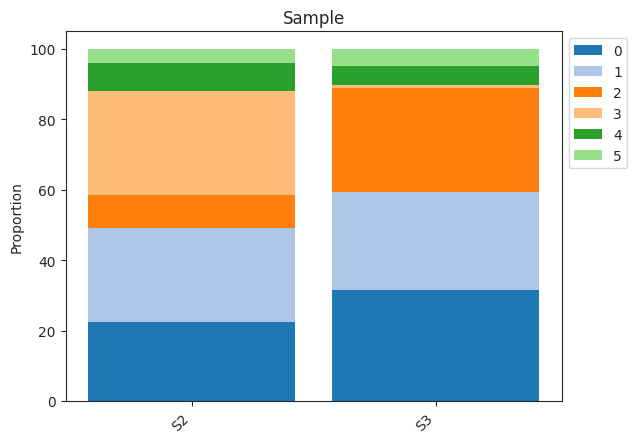

In [61]:
pt.pl.coda.stacked_barplot(sccoda_data, modality_key="coda", feature_name="Sample")
plt.show()

In [62]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Sample",
    reference_cell_type="automatic",
)


Automatic reference selection! Reference cell type set to 1

In [70]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=3456)
sccoda_data["coda"]

sample: 100%|██████████| 11000/11000 [00:12<00:00, 895.36it/s, 127 steps of size 4.43e-02. acc. prob=0.69] 


AnnData object with n_obs × n_vars = 2 × 6
    obs: 'Sample'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_Sample[T.S3]'

In [75]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda", extended=True)


                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 2 samples, 6 cell types                                           │
│ Reference cell type                   │ 1                                                                       │
│ Formula                               │ Sample                                                                  │
│ Reference index                       │ 1                                                                       │
│ Spike-and-slab threshold              │ 0.704                                                                   │
│ Spike-and-slab threshold              │ 0.704                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 69.2%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                                              │
│ Cell Type                                                                                                       │
│ 0              2.417         0.245  4.665   1.209     367.722                                                   │
│ 1              2.485         0.434  4.697   1.194     393.597                                                   │
│ 2              1.703        -0.302  3.720   1.101     180.067                                                   │
│ 3              2.225        -0.876  4.937   1.662     303.484                                                   │
│ 4              1.180        -0.965  3.430   1.209     106.733                                                   │
│ 5              0.735        -1.319  2.942   1.165      68.397                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       Final Parameter  Expected Sample  log2-fold change                                        │
│ Covariate  Cell Type                                                                                            │
│ SampleT.S3 0               0.000          377.204             0.037                                             │
│            1               0.000          403.747             0.037                                             │
│            2               0.849          431.911             1.262                                             │
│            3              -2.427           27.493            -3.464                                             │
│            4               0.000          109.485             0.037                                             │
│            5               0.000           70.161             0.037                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                       HDI 3%  HDI 97%   SD   Inclusion probability                                              │
│ Covariate  Cell Type                                                                                            │
│ SampleT.S3 0          -0.723  1.182   0.324         0.374                                                       │
│            1           0.000  0.000   0.000         0.000                                                       │
│            2          -0.211  1.929   0.639         0.705                                                       │
│            3          -4.434  0.196   1.442         0.900                                                       │
│            4          -1.581  0.936   0.443         0.401                                                       │
│            5          -1.407  1.421   0.444         0.387                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘